In [ ]:
library('caret')
library('reshape2')
library('ggplot2')
# library('gbm')

# library('DESeq2')
library('tidyverse')
# library('EnhancedVolcano')
# library('gplots')
# library('org.Hs.eg.db')
# library('clusterProfiler')

library(doParallel)
cl <- makePSOCKcluster(16)
registerDoParallel(cl)

Loading required package: lattice

Loading required package: ggplot2

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ tibble  3.1.0     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1
✔ purrr   0.3.4     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ purrr::lift()   masks caret::lift()

Loading required package: foreach


Attaching package: ‘foreach’


The following objects are masked from ‘package:purrr’:

    accumulate, when


Loading required package: iterators

Loading required package: parallel



In [ ]:
x_train = read.delim('Train_call.txt', header = TRUE, sep = "\t", quote = "\"", dec = ".", fill = TRUE, comment.char = "")
y_train = read.delim('Train_clinical.txt', header = TRUE, sep = "\t", quote = "\"", dec = ".", fill = TRUE, comment.char = "", row.names = 1)

x_train = t(x_train)

In [ ]:
data <- merge(y_train, x_train[5:nrow(x_train),], by = 'row.names')
row.names(data) <- data$Row.names
data$Row.names <- NULL
dim(data)
head(data)

[1]  100 2835

,Subgroup,V1,V2,V3,V4,V5,V6,V7,V8,V9,⋯,V2825,V2826,V2827,V2828,V2829,V2830,V2831,V2832,V2833,V2834
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
Array.10,HER2+,0,0,0,0,0,0,0,0,0,⋯,1,1,0,1,1,1,1,1,1,1
Array.100,HR+,0,0,0,0,0,0,0,0,0,⋯,1,1,1,1,1,1,1,1,1,1
Array.101,HR+,0,0,1,1,1,1,1,1,1,⋯,1,1,1,1,1,1,1,1,1,1
Array.102,Triple Neg,0,0,0,0,-1,-1,-1,0,-1,⋯,1,1,1,1,1,1,1,1,1,1
Array.104,Triple Neg,0,0,0,0,0,0,0,0,0,⋯,1,1,1,1,1,1,1,1,1,1
Array.105,HER2+,0,0,0,0,0,0,0,0,-1,⋯,2,1,1,1,1,1,1,2,2,2


In [ ]:
# for reproducibility: The first use of random numbers is to create the resampling information
set.seed(123)

overall_accuracies = NULL
for (j in seq(100)) {
    start_time <- Sys.time()
# ---------------------------------------------------------------------------------------
    msk <- createDataPartition(data[,'Subgroup'], p = 0.8, list = FALSE, times = 1)
    # split the data into training and test set
    dataTrain  <- data[msk, ] # 81 instances
    dataTest <- data[-msk, ]  # 19 instances

    rocVarImp <- filterVarImp(dataTrain[, -which(names(dataTrain) == "Subgroup")],
                              factor(dataTrain[, 'Subgroup']) , nonpara = FALSE)

    rocVarImpSum <- apply(rocVarImp, 1, sum)
    # print(as.data.frame(rocVarImpSum))
    max(rocVarImpSum)
    which.max(rocVarImpSum)
    # plot(rocVarImpSum)
    rocVarImpSum_sorted <- sort(rocVarImpSum, decreasing = TRUE)
    # sort the initial dataframe based on the sorted scores
    sorted_idx <- strtoi(substring(names(rocVarImpSum_sorted), 2))
    sorted_idx <- paste0('V', sorted_idx)
    write.csv(sorted_idx, file = paste0("splits/features_split", j, ".csv"))
# ---------------------------------------------------------------------------------------
    # Set up Repeated k-fold Cross Validation
    train_control <- trainControl(method="repeatedcv",
                                  number=10,
                                  repeats=3,
                                  search = "random")


    methods <- c('svmLinear3')

    i = 0
    res = NULL
    for (n in seq(1, nrow(dataTrain)+20, 1)) {
        temp_data <- dataTrain[,c('Subgroup', sorted_idx[1:n])]
        for (method in methods) {
            i = i + 1
            # Fit the model 
            svm <- train(Subgroup ~., data = temp_data, method = method, trControl = train_control, tuneLength = 10)
            res = bind_rows(res, as_tibble(c(svm$results[which.max(svm$results[,'Accuracy']),], list(split = j, predictors = n, method = method))))
            #View the model
#             print(svm)
#             print('--------------------------------------')
        }
#         print(paste0('Predictors ', n , ' done.'))
    }
    print(paste0('Total models: ',i))
    write.csv(res , file = paste0("splits/results_training_s1_split", j, ".csv"))
# ---------------------------------------------------------------------------------------

#     res <- read.csv('results_training_s1.csv')
    optimal_params <- as.data.frame(res[which.max(as.numeric(unlist(res['Accuracy']))), c('Loss', 'predictors', #change this
                                                                           'method', 'cost')])

    train_control <- trainControl(method="none")
    tuneGrid = expand.grid(Loss = optimal_params$Loss, #this
                           cost = optimal_params$cost) #and this


    temp_data <- dataTrain[,c('Subgroup', sorted_idx[1:optimal_params[,'predictors']])]
    svm <- train(Subgroup ~., data = temp_data, method = optimal_params$method, trControl = train_control, 
                 tuneGrid = tuneGrid)
    print(svm)

    y_pred = predict(svm, newdata = dataTest[,sorted_idx[1:optimal_params[,'predictors']]])

    overall_accuracies = c(overall_accuracies, 
                           confusionMatrix(data = y_pred, as.factor(dataTest[, 'Subgroup']))$overall[['Accuracy']])

    ggplot() + 
        geom_line(data = res, aes(x = predictors, y = Accuracy, group = method, color=method)) +
        ylab(label="Accuracy") +
        xlab("Predictors") + 
        ggtitle("Optimized models using random grid search and 10-fold CV\nfor different number of significant predictors in descending order.") + 
        labs(color="Methods")
    ggsave(paste0("splits/training_s1_split", j, ".png"))
    end_time <- Sys.time()
    print(end_time - start_time)
    print(paste0('Split ', j , ' done.'))
}

[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

81 samples
91 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 2.124464 mins
[1] "Split 1 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

81 samples
99 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 2.277714 mins
[1] "Split 2 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

81 samples
65 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 2.022234 mins
[1] "Split 3 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

81 samples
75 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 2.221382 mins
[1] "Split 4 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

81 samples
84 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 1.912694 mins
[1] "Split 5 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

81 samples
98 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 2.835458 mins
[1] "Split 6 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

 81 samples
100 predictors
  3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 2.139344 mins
[1] "Split 7 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

 81 samples
101 predictors
  3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 2.225442 mins
[1] "Split 8 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

81 samples
88 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 2.213692 mins
[1] "Split 9 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

81 samples
85 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 2.089635 mins
[1] "Split 10 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

81 samples
98 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 2.147099 mins
[1] "Split 11 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

81 samples
97 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 2.291108 mins
[1] "Split 12 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

 81 samples
100 predictors
  3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 1.84951 mins
[1] "Split 13 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

81 samples
71 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 1.922689 mins
[1] "Split 14 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

81 samples
64 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 1.959793 mins
[1] "Split 15 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

81 samples
38 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 2.380542 mins
[1] "Split 16 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

81 samples
80 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 2.210846 mins
[1] "Split 17 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

81 samples
86 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 1.775129 mins
[1] "Split 18 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

81 samples
18 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 2.327963 mins
[1] "Split 19 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

81 samples
58 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 1.744569 mins
[1] "Split 20 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

81 samples
72 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 2.253309 mins
[1] "Split 21 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

81 samples
97 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 2.212747 mins
[1] "Split 22 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

81 samples
66 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 2.020104 mins
[1] "Split 23 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

81 samples
77 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 2.013636 mins
[1] "Split 24 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

81 samples
75 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 2.167352 mins
[1] "Split 25 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

81 samples
63 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 1.880708 mins
[1] "Split 26 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

81 samples
64 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 2.384217 mins
[1] "Split 27 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

81 samples
88 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 2.254774 mins
[1] "Split 28 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

 81 samples
101 predictors
  3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 1.771365 mins
[1] "Split 29 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

81 samples
86 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 2.112244 mins
[1] "Split 30 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

81 samples
95 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 2.198512 mins
[1] "Split 31 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

81 samples
81 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 2.410965 mins
[1] "Split 32 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

81 samples
44 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 1.835098 mins
[1] "Split 33 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

81 samples
72 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 2.080909 mins
[1] "Split 34 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

81 samples
87 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 2.660156 mins
[1] "Split 35 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

81 samples
80 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 2.463481 mins
[1] "Split 36 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

81 samples
54 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 1.800555 mins
[1] "Split 37 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

81 samples
75 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 2.165699 mins
[1] "Split 38 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

81 samples
26 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 2.206957 mins
[1] "Split 39 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

81 samples
98 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 2.195626 mins
[1] "Split 40 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

 81 samples
100 predictors
  3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 2.23527 mins
[1] "Split 41 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

81 samples
80 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 2.245008 mins
[1] "Split 42 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

81 samples
15 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 1.860211 mins
[1] "Split 43 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

81 samples
67 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 2.307249 mins
[1] "Split 44 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

81 samples
93 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 2.374916 mins
[1] "Split 45 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

 81 samples
100 predictors
  3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 2.370685 mins
[1] "Split 46 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

81 samples
96 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 2.143472 mins
[1] "Split 47 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

81 samples
52 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 2.312519 mins
[1] "Split 48 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

81 samples
99 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 2.053413 mins
[1] "Split 49 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

81 samples
16 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 2.215863 mins
[1] "Split 50 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

81 samples
59 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 2.462528 mins
[1] "Split 51 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

81 samples
99 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 2.356609 mins
[1] "Split 52 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

81 samples
37 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 1.850835 mins
[1] "Split 53 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

81 samples
65 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 2.212702 mins
[1] "Split 54 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

81 samples
48 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 2.350868 mins
[1] "Split 55 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

 81 samples
101 predictors
  3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 2.25794 mins
[1] "Split 56 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

81 samples
60 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 2.075105 mins
[1] "Split 57 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

81 samples
90 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 2.187446 mins
[1] "Split 58 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

81 samples
94 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 2.069433 mins
[1] "Split 59 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

81 samples
93 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 2.080748 mins
[1] "Split 60 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

81 samples
45 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 1.935461 mins
[1] "Split 61 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

81 samples
90 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 2.391747 mins
[1] "Split 62 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

81 samples
74 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 2.69686 mins
[1] "Split 63 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

81 samples
95 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 2.115288 mins
[1] "Split 64 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

81 samples
92 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 2.252019 mins
[1] "Split 65 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

81 samples
62 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 2.128163 mins
[1] "Split 66 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

81 samples
50 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 2.128298 mins
[1] "Split 67 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

 81 samples
100 predictors
  3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 2.613084 mins
[1] "Split 68 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

81 samples
44 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 1.546971 mins
[1] "Split 69 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

81 samples
85 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 2.370836 mins
[1] "Split 70 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

 81 samples
101 predictors
  3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 1.932006 mins
[1] "Split 71 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

81 samples
48 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 2.212774 mins
[1] "Split 72 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

81 samples
89 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 2.176329 mins
[1] "Split 73 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

81 samples
97 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 2.507119 mins
[1] "Split 74 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

81 samples
94 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 1.97186 mins
[1] "Split 75 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

81 samples
70 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 1.74274 mins
[1] "Split 76 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

81 samples
78 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 2.532597 mins
[1] "Split 77 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

81 samples
88 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 2.164011 mins
[1] "Split 78 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

 81 samples
101 predictors
  3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 2.426219 mins
[1] "Split 79 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

81 samples
86 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 2.553478 mins
[1] "Split 80 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

81 samples
59 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 2.778311 mins
[1] "Split 81 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

81 samples
95 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 2.227098 mins
[1] "Split 82 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

81 samples
98 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 2.034185 mins
[1] "Split 83 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

81 samples
98 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 1.685238 mins
[1] "Split 84 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

81 samples
22 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 2.34656 mins
[1] "Split 85 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

81 samples
80 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 2.203027 mins
[1] "Split 86 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

81 samples
99 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 2.797131 mins
[1] "Split 87 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

81 samples
90 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 2.114051 mins
[1] "Split 88 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

 81 samples
101 predictors
  3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 2.144717 mins
[1] "Split 89 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

81 samples
93 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 2.347065 mins
[1] "Split 90 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

81 samples
89 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 1.87441 mins
[1] "Split 91 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

81 samples
91 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 2.408314 mins
[1] "Split 92 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

81 samples
80 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 2.032355 mins
[1] "Split 93 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

81 samples
80 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 2.210436 mins
[1] "Split 94 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

81 samples
84 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 2.445573 mins
[1] "Split 95 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

81 samples
63 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 1.91087 mins
[1] "Split 96 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

81 samples
61 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 2.156364 mins
[1] "Split 97 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

81 samples
76 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 2.356495 mins
[1] "Split 98 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

81 samples
33 predictors
 3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 2.166714 mins
[1] "Split 99 done."
[1] "Total models: 101"
L2 Regularized Support Vector Machine (dual) with Linear Kernel 

 81 samples
100 predictors
  3 classes: 'HER2+', 'HR+', 'Triple Neg' 

No pre-processing
Resampling: None 


Saving 6.67 x 6.67 in image



Time difference of 2.633896 mins
[1] "Split 100 done."


In [ ]:
stopCluster(cl)

[1] 0.78

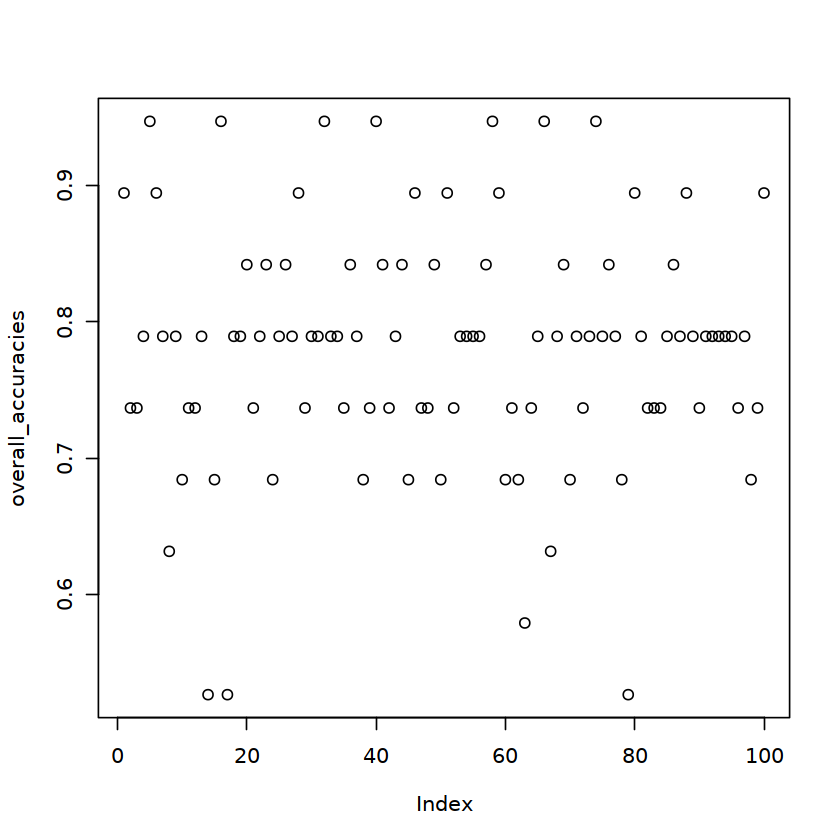

In [ ]:
mean(overall_accuracies)
plot(overall_accuracies)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=39982db8-5b4c-4eff-a4a1-5a43e95600e9' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>